In [ ]:
import 

# The lookuptable boundaries.

* Absolute lower end (polar/high-alt winter): ~0.05–0.1 mm (rare), 0.2–0.5 mm (very dry but observed), 1–3 mm (common on Antarctic plateau/Atacama winters).
* Dry subtropics & high deserts (low–mid elev.): 3–15 mm typical, 20–25 mm on humid days.
* Mid-lat maritime/humid: 10–35 mm typical, 40–50 mm during warm spells.
* Tropics over warm oceans: 35–60 mm typical; 65–75 mm in very moist conditions.
* Extremes (atmospheric rivers/equatorial maxima): ~75–85 mm have been observed; >85 mm is extraordinary and short-lived.

In [55]:
#airmass
am_min = 1
am_max = 12
am_range = np.linspace(am_min,am_max, 20)
am_range

array([ 1.        ,  1.57894737,  2.15789474,  2.73684211,  3.31578947,
        3.89473684,  4.47368421,  5.05263158,  5.63157895,  6.21052632,
        6.78947368,  7.36842105,  7.94736842,  8.52631579,  9.10526316,
        9.68421053, 10.26315789, 10.84210526, 11.42105263, 12.        ])

In [56]:
#solar zenith angle range
za_range = 90 - np.rad2deg(np.arcsin(1/am_range))
za_range

array([ 0.        , 50.70351976, 62.39233194, 68.5687455 , 72.4470349 ,
       75.12229379, 77.08358265, 78.58484226, 79.7717435 , 80.7340715 ,
       81.53027352, 82.20007441, 82.77143647, 83.26462257, 83.69468068,
       84.07302295, 84.40846294, 84.70791642, 84.9768867 , 85.21980815])

In [57]:
# pmv
pwv_min = 0.01
pwv_max = 10
pwv_range = np.logspace(np.log10(pwv_min), np.log10(pwv_max), 20)
pwv_range

array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])

# Make the LBLrtm LUT

In [58]:
import tapefive.lab as tf

In [59]:
reload(tf)
reload(tf.tape5parser)
reload(tf.tools)
reload(tf.fileio)

<module 'tapefive.fileio' from '/home/hagen/prog/tapefive/tapefive/fileio.py'>

In [60]:
%%time
pwv1norm = 0.3458833686192847

# pwv = 1
dslist_pwv = []
for pwv in pwv_range:
    dslist_za = []
    for z in za_range:
        print('.', end = '')
        run = tf.Lblrtm(verbose=False)
        run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
        run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
        run.configuration.spectral_grid.layering_control = 'exact'
        run.configuration.spectral_grid.df = 0.05
        run.configuration.atmospheric_layers
        run.configuration.geometry.slant_angle = z
        run.configuration.rayleigh.enabled = False
        run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
        run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
        run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwv # 
        run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
        run_dir = run
        res_dir = run.run()
        dslist_za.append(res_dir.data.optical_depth.expand_dims(dim = {'solar_zenith_angle': [z]}))
    da =xr.concat(dslist_za, 'solar_zenith_angle')
    dslist_pwv.append(da.expand_dims(dim = {'pwv': [pwv]}))
ds = xr.concat(dslist_pwv, 'pwv')

................................................................................................................................................................................................................................................................................................................................................................................................................CPU times: user 930 ms, sys: 162 ms, total: 1.09 s
Wall time: 2min 43s


In [61]:
fn = pl.Path('data/lut_mfrsr2pwv_0.1.nc').resolve()

In [62]:
if not fn.exists():
    ds.to_netcdf(fn)
else:
    print('file exists')

sh: 1: getfattr: not found


In [63]:
da_sum = ds.sum('wavenumber')

In [64]:
da_sum

<xarray.DataArray 'optical_depth' (pwv: 20, solar_zenith_angle: 20)> Size: 3kB
array([[1.65484512e+02, 2.61171777e+02, 3.56736367e+02, 4.52179550e+02,
        5.47404041e+02, 6.42103505e+02, 7.36564250e+02, 8.30608497e+02,
        9.24642302e+02, 1.01774671e+03, 1.11105620e+03, 1.20349625e+03,
        1.29511958e+03, 1.38570443e+03, 1.47624462e+03, 1.56654961e+03,
        1.65713315e+03, 1.74604249e+03, 1.83444826e+03, 1.92071629e+03],
       [2.38043401e+02, 3.75686016e+02, 5.13152177e+02, 6.50443637e+02,
        7.87420599e+02, 9.23642363e+02, 1.05952063e+03, 1.19482011e+03,
        1.33005860e+03, 1.46399258e+03, 1.59821472e+03, 1.73116816e+03,
        1.86294941e+03, 1.99330457e+03, 2.12352734e+03, 2.25343130e+03,
        2.38367383e+03, 2.51154821e+03, 2.63874333e+03, 2.76284022e+03],
       [3.42414536e+02, 5.40407154e+02, 7.38145919e+02, 9.35633427e+02,
        1.13266857e+03, 1.32861728e+03, 1.52407199e+03, 1.71867176e+03,
        1.91324591e+03, 2.10589060e+03, 2.29898802e+03, 2.49020604e+03,
        2.67980528e+03, 2.86728388e+03, 3.05459416e+03, 3.24144892e+03,
        3.42881266e+03, 3.61278078e+03, 3.79574422e+03, 3.97419234e+03],
       [4.92548020e+02, 7.77351549e+02, 1.06178992e+03, 1.34586683e+03,
        1.62929312e+03, 1.91115656e+03, 2.19230947e+03, 2.47227109e+03,
        2.75210542e+03, 3.02922991e+03, 3.30695624e+03, 3.58204109e+03,
        3.85478984e+03, 4.12442748e+03, 4.39386516e+03, 4.66267835e+03,
        4.93220541e+03, 5.19685346e+03, 5.45990286e+03, 5.71675656e+03],
...
       [5.57196568e+04, 8.79381743e+04, 1.20115425e+05, 1.52251846e+05,
        1.84314724e+05, 2.16200877e+05, 2.48006734e+05, 2.79675227e+05,
        3.11330815e+05, 3.42682124e+05, 3.74103889e+05, 4.05226077e+05,
        4.36074993e+05, 4.66586263e+05, 4.97071603e+05, 5.27479410e+05,
        5.57968095e+05, 5.87900027e+05, 6.17671595e+05, 6.46727883e+05],
       [8.02243689e+04, 1.26612158e+05, 1.72940550e+05, 2.19210176e+05,
        2.65373957e+05, 3.11283371e+05, 3.57077197e+05, 4.02670347e+05,
        4.48249209e+05, 4.93392901e+05, 5.38633556e+05, 5.83433308e+05,
        6.27848511e+05, 6.71781353e+05, 7.15666227e+05, 7.59448079e+05,
        8.03354185e+05, 8.46462020e+05, 8.89330411e+05, 9.31153446e+05],
       [1.15546949e+05, 1.82359192e+05, 2.49085948e+05, 3.15728101e+05,
        3.82217902e+05, 4.48341425e+05, 5.14298597e+05, 5.79967324e+05,
        6.45619235e+05, 7.10643813e+05, 7.75795568e+05, 8.40332099e+05,
        9.04317338e+05, 9.67583698e+05, 1.03079056e+06, 1.09384679e+06,
        1.15709449e+06, 1.21918798e+06, 1.28091847e+06, 1.34115904e+06],
       [1.66507447e+05, 2.62786437e+05, 3.58942313e+05, 4.54976446e+05,
        5.50791172e+05, 6.46078228e+05, 7.41125820e+05, 8.35761200e+05,
        9.30364009e+05, 1.02405377e+06, 1.11795533e+06, 1.21097101e+06,
        1.30314774e+06, 1.39433518e+06, 1.48542833e+06, 1.57630681e+06,
        1.66746172e+06, 1.75690623e+06, 1.84591066e+06, 1.93272989e+06]])
Coordinates:
  * pwv                 (pwv) float64 160B 0.01 0.01438 0.02069 ... 6.952 10.0
  * solar_zenith_angle  (solar_zenith_angle) float64 160B 0.0 50.7 ... 85.22

In [69]:
%matplotlib inline

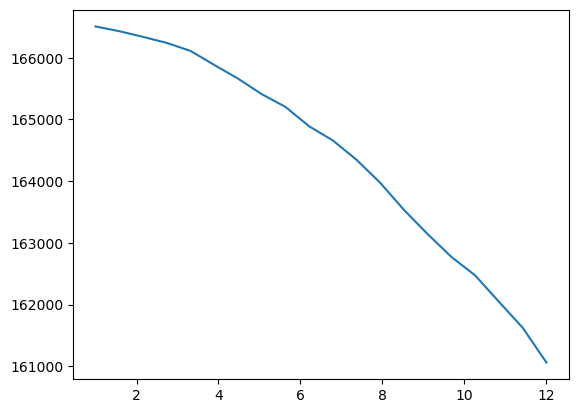

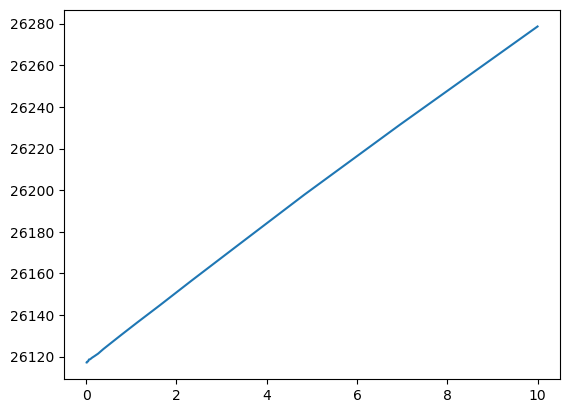

In [76]:
dasel = da_sum.isel(pwv = 19)
am = 1/np.cos(np.deg2rad(dasel.solar_zenith_angle))
f,a = plt.subplots()
a.plot(am, dasel/am)
f,a = plt.subplots()
dasel = da_sum.isel(solar_zenith_angle = 1)
a.plot(dasel.pwv, dasel/dasel.pwv)

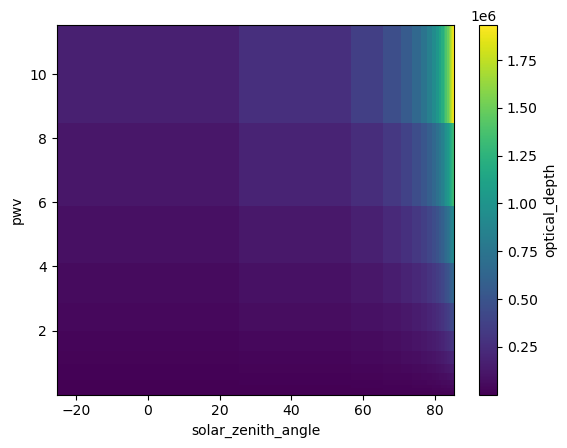

In [72]:
da_sum.plot()

# find best cm resolution for lut

Conclusion: 0.05 looks fine to me

In [ ]:
import tapefive.lab as tf

In [2]:
reload(tf)
reload(tf.tape5parser)
reload(tf.tools)
reload(tf.fileio)

<module 'tapefive.fileio' from '/home/hagen/prog/tapefive/tapefive/fileio.py'>

In [12]:
import scipy as sp

In [40]:
pwv1norm = 0.3458833686192847
pwv = 1
z = 0
df = 0.0025
od1 = None
while 1:
    run = tf.Lblrtm(verbose=False)
    run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
    run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
    run.configuration.spectral_grid.layering_control = 'exact'
    df *= 1.1
    run.configuration.spectral_grid.df = df
    run.configuration.atmospheric_layers
    run.configuration.geometry.slant_angle = z
    run.configuration.rayleigh.enabled = False
    run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
    run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
    run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwv # 
    run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
    run_dir = run
    res_dir = run.run()
    ds = res_dir.data
    od = ds.optical_depth.sum()/ds.wavenumber.shape[0]
    if isinstance(od1, type(None)):
        od1 = od
        continue
    else:
        print(f'df = {df:0.3f}, odratio = {od1/od:0.4f}')
    

df = 0.003, odratio = 1.0000
df = 0.003, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.005, odratio = 1.0000
df = 0.005, odratio = 1.0000
df = 0.006, odratio = 1.0000
df = 0.006, odratio = 1.0000
df = 0.007, odratio = 1.0000
df = 0.008, odratio = 1.0000
df = 0.009, odratio = 1.0000
df = 0.009, odratio = 1.0000
df = 0.010, odratio = 1.0000
df = 0.011, odratio = 1.0000
df = 0.013, odratio = 1.0000
df = 0.014, odratio = 1.0000
df = 0.015, odratio = 1.0000
df = 0.017, odratio = 1.0000
df = 0.019, odratio = 1.0000
df = 0.020, odratio = 1.0000
df = 0.022, odratio = 1.0000
df = 0.025, odratio = 1.0000
df = 0.027, odratio = 1.0001
df = 0.030, odratio = 1.0000
df = 0.033, odratio = 1.0001
df = 0.036, odratio = 1.0001
df = 0.040, odratio = 1.0001
df = 0.044, odratio = 1.0001
df = 0.048, odratio = 1.0001
df = 0.053, odratio = 1.0000
df = 0.058, odratio = 1.0000
df = 0.064, odratio = 0.9999
df = 0.070, odratio = 0.9999
df = 0.077, od

KeyboardInterrupt: 

In [50]:
run = tf.Lblrtm(verbose=False)
run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
run.configuration.spectral_grid.layering_control = 'exact'
df *= 1.1
run.configuration.spectral_grid.df = 0.05
run.configuration.atmospheric_layers
run.configuration.geometry.slant_angle = 0
run.configuration.rayleigh.enabled = False
run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * 1 # 
run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
run_dir = run
res_dir = run.run()

In [51]:
da = res_dir.data.optical_depth

In [52]:
da

<xarray.DataArray 'optical_depth' (wavenumber: 14601)> Size: 117kB
array([0.09661572, 0.12589198, 0.1730688 , ..., 0.05798897, 0.05985783,
       0.04110217], shape=(14601,))
Coordinates:
  * wavenumber  (wavenumber) float64 117kB 1.028e+04 1.028e+04 ... 1.101e+04
Attributes:
    long_name:  optical_depth
    units:      1

In [53]:
%matplotlib widget

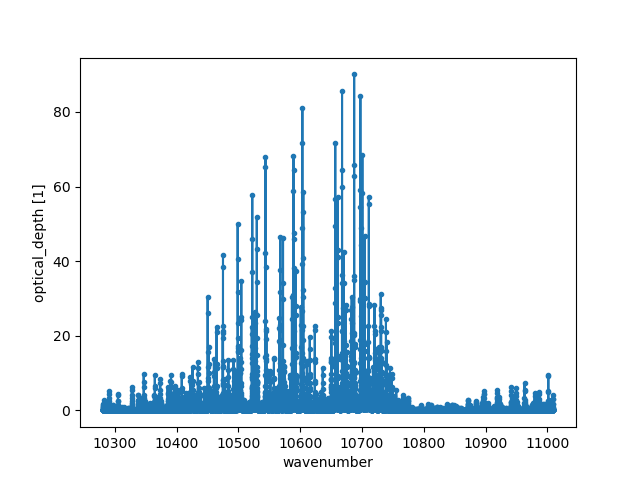

In [54]:
f, a = plt.subplots()
da.plot(marker = '.', ax= a)

In [36]:
ds1.optical_depth.sum()/ds1.wavenumber.shape[0]

<xarray.DataArray 'optical_depth' ()> Size: 8B
array(1.13422579)

In [37]:
ds2.optical_depth.sum()/ds2.wavenumber.shape[0]

<xarray.DataArray 'optical_depth' ()> Size: 8B
array(1.13422879)

In [29]:
ds1.wavenumber.shape[0]

(146001,)

In [25]:
sp.integrate.simpson(ds1.optical_depth, ds1.wavenumber)

np.float64(63657.64207317187)

In [26]:
sp.integrate.simpson(ds2.optical_depth, ds2.wavenumber)

np.float64(63657.58947478761)

In [13]:
bla2 = sp.integrate.simpson(res_dir.data.optical_depth)

In [10]:
bla = sp.integrate.simpson(res_dir.data.optical_depth)

In [22]:
bla

np.float64(12731528.41463447)

In [23]:
bla2

np.float64(25463035.789915033)

In [6]:
res_dir.data.optical_depth

<xarray.DataArray 'optical_depth' (wavenumber: 146001)> Size: 1MB
array([8.10184226, 8.27621179, 8.50305897, ..., 3.66665414, 3.54811335,
       3.43092476], shape=(146001,))
Coordinates:
  * wavenumber  (wavenumber) float64 1MB 1.028e+04 1.028e+04 ... 1.101e+04
Attributes:
    long_name:  optical_depth
    units:      1

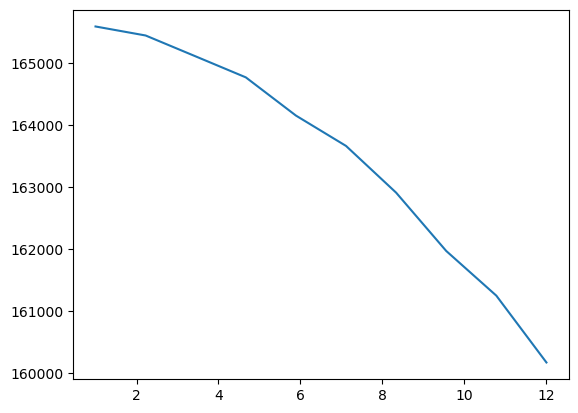

In [81]:
f,a = plt.subplots()
am = 1/np.cos(np.deg2rad(sza_dep.solar_zenith_angle))
a.plot(am, sza_dep/am)

In [70]:
res_dir.data.optical_depth.expand_dims(dim = {'solar_zenith_angle': [z]})

<xarray.DataArray 'optical_depth' (solar_zenith_angle: 1, wavenumber: 146001)> Size: 1MB
array([[0.09661572, 0.09877422, 0.1015091 , ..., 0.04429482, 0.04268024,
        0.04110217]], shape=(1, 146001))
Coordinates:
  * solar_zenith_angle  (solar_zenith_angle) float64 8B 0.0
  * wavenumber          (wavenumber) float64 1MB 1.028e+04 ... 1.101e+04
Attributes:
    long_name:  optical_depth
    units:      1

In [ ]:
xr.DataArray.expand_dims()

# The convolution

## get a filter function

In [ ]:
# does 

In [ ]:
imp